#### Import datasets

In [1]:
import mne
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

In [2]:
runs = [6, 10, 14]  # motor imagery: hands vs feet

source_fnames = eegbci.load_data(1, runs)
source = concatenate_raws([read_raw_edf(f, preload=True) for f in source_fnames])
eegbci.standardize(source)  # set channel names
montage = make_standard_montage("standard_1005")
source.set_montage(montage)
source.annotations.rename(dict(T0="rest", T1="hands", T2="feet"))
source.set_eeg_reference(projection=True)

Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from C:\Users\zeyad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\zeyad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\zeyad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the appl

Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,67 points
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,0.00 Hz
Lowpass,80.00 Hz


#### Preprocess source data

In [3]:
# print channel names
print(source.ch_names)

['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']


In [4]:
from scripts.preprocessing import Preprocessing

source_preprocessing = Preprocessing(source)
source_preprocessing.preprocess_raw()
source_epochs = source_preprocessing.segment_into_epochs(['hands', 'feet'], channels=["C3", "C4", "P3", "P4", "T7", "T8", "P7", "P8"])

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 265 samples (1.656 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 6.4s.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


f:\zeyad\Documents\repos\general-bci-tl-classifier\scripts\preprocessing.py:42: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(self.processed_raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 8 ICA components
    Projecting back using 64 PCA components
Used Annotations descriptions: ['feet', 'hands', 'rest']
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


In [5]:
# print label counts
print(source_epochs["feet"])
print(source_epochs["hands"])

<Epochs |  24 events (all good), -1 – 4 s, baseline off, ~1.2 MB, data loaded,
 'feet': 24>
<Epochs |  21 events (all good), -1 – 4 s, baseline off, ~1.1 MB, data loaded,
 'hands': 21>


#### Simulate real time data

##### Prepare calibration data

In [6]:
# calibration data
target_fnames = eegbci.load_data(2, [6])
target = concatenate_raws([read_raw_edf(f, preload=True) for f in target_fnames])
eegbci.standardize(target)
target.set_montage(montage)
target.annotations.rename(dict(T0="rest", T1="hands", T2="feet"))
target.set_eeg_reference(projection=True)

# preprocessing
target_preprocessing = Preprocessing(target)
target_preprocessing.preprocess_raw()
target_epochs = target_preprocessing.segment_into_epochs(['hands', 'feet'], channels=["C3", "C4", "P3", "P4", "T7", "T8", "P7", "P8"])

Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from C:\Users\zeyad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S002\S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.8s.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


f:\zeyad\Documents\repos\general-bci-tl-classifier\scripts\preprocessing.py:42: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(self.processed_raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 6 ICA components
    Projecting back using 64 PCA components
Used Annotations descriptions: ['feet', 'hands', 'rest']
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 801 original time points ...
0 bad epochs dropped


##### Label alignment & TS mapping

In [136]:
from scripts.label_alignment import LabelAlignment
import numpy as np

source_events = source_epochs.events[:, -1]
label_alignment = LabelAlignment(source_epochs, target_epochs)
source_aligned = label_alignment.transform()

# append target data to source data
source_aligned = np.concatenate([source_aligned, target_epochs.get_data()])
source_events = np.concatenate([source_events, target_epochs.events[:, -1]])

C:\Users\zeyad\AppData\Local\Temp\ipykernel_1172\235689436.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  source_aligned = np.concatenate([source_aligned, target_epochs.get_data()])


In [137]:
from scripts.ts_feature_extraction import tangent_space_mapping

source_ts = tangent_space_mapping(source_aligned)

##### Train model

In [111]:
# rt data
rt_fnames = eegbci.load_data(2, [10, 14])
rt = concatenate_raws([read_raw_edf(f, preload=True) for f in rt_fnames])
eegbci.standardize(rt)
rt.set_montage(montage)
rt.annotations.rename(dict(T0="rest", T1="hands", T2="feet"))
rt.set_eeg_reference(projection=True)

# preprocessing
rt_preprocessing = Preprocessing(rt)
rt_preprocessing.preprocess_raw()
rt_epochs = rt_preprocessing.segment_into_epochs(['hands', 'feet'], channels=["C3", "C4", "P3", "P4", "T7", "T8", "P7", "P8"])

Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from C:\Users\zeyad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S002\S002R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from C:\Users\zeyad\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S002\S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 5.8s.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


f:\zeyad\Documents\repos\general-bci-tl-classifier\scripts\preprocessing.py:42: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(self.processed_raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
Used Annotations descriptions: ['feet', 'hands', 'rest']
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 801 original time points ...
0 bad epochs dropped


              precision    recall  f1-score   support

           1       0.79      0.79      0.79        14
           2       0.81      0.81      0.81        16

    accuracy                           0.80        30
   macro avg       0.80      0.80      0.80        30
weighted avg       0.80      0.80      0.80        30



C:\Users\zeyad\AppData\Local\Temp\ipykernel_1172\286597708.py:15: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_test = tangent_space_mapping(rt_epochs.get_data())


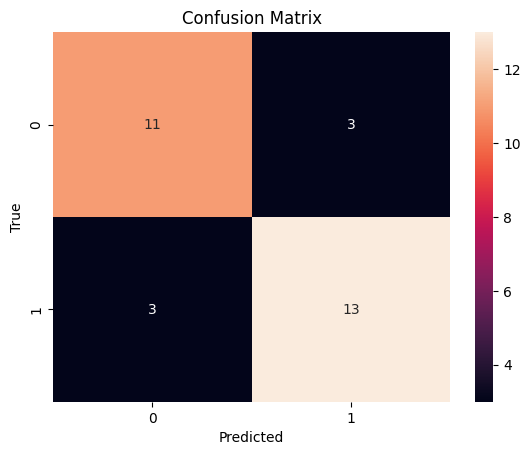

In [140]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report

X = source_ts
y = source_events

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = X, y
X_test = tangent_space_mapping(rt_epochs.get_data())
y_test = rt_epochs.events[:, -1]

# Create and fit the classifier
lda =  LDA()
clf = make_pipeline(StandardScaler(), lda)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()